In [17]:
# Bloc non affiché

import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score, matthews_corrcoef, make_scorer

from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
import xgboost as xgb




from sklearn.ensemble import RandomForestClassifier




def result_model(model,X,Y, mat = True, f1=True) :
    Y_model =model.predict(X)
    if f1:
        f1_scor = f1_score(Y,Y_model)
        print('Le f1 score vaut',f1_scor)
    
#     score = cross_val_score(model,X,Y,cv=5,scoring = make_scorer(f1_score))
#     print('F1 cross validé :', np.mean(score))
    
    if mat:
    # Matrice de confusion
        cm_model = confusion_matrix(Y, Y_model)
        plt.rcParams['figure.figsize'] = (5, 5)
        sns.heatmap(cm_model, annot = True)
        plt.title(str(model))
        plt.show()
    

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 6

# Modèle finale

## Téléchargement des données

In [10]:
train = pd.read_csv("https://www.data.mclavier.com/prj_datascience/train_v1.csv")

## Pre-processing

On sépare dans un premier temps les variables explicatives et la variable à expliquer.

In [11]:
X = train.drop(columns='Response')
Y = train['Response']

Le modèle final sera entrainé sur l'intégralité de la base que nous possédons. Mais actuellement, nous souhaitons mesure le caractère prédictif de nos données et donc pour éviter l'overfitting, nous séparons tout de même nos données.

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,train_size = 0.85)

rus = RandomUnderSampler(sampling_strategy = 0.844)
X_rus , Y_rus = rus.fit_resample(X_train ,Y_train)

## Modèle

Au final, nous avons tester 7 modèles. Voici leur F1-Score respectif :
- **Logistique** (sans tuning) : 0.22
- **SCV** (sans tuning) : 0.13
- **CART** (sans tuning) : 0.43
- **Random Forest** (avec tuning) : 0.55
- **Réseau de neuronnes** (sans tuning) : 0.22 (keras) et 0.41 (sklearn)
- **Gradient Boost** (sans tuning): 0.39
- **XGBoost** (avec tuning) : 0.58*



\* : *obtenu dans le notebook précédent.*

Nous utilisons donc le **XGBoost** pour nos prévisions finales avec des données équilibrées avec coefficient $\alpha = 0.844$.

In [13]:
params_xgb = {
    'objective': 'binary:logistic',
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'gpu_id': -1,
    'interaction_constraints': '',
    'learning_rate': 0.300000012,
    'max_delta_step': 0,
    'max_depth': 3,
    'min_child_weight': 4,
    'monotone_constraints': '()',
    'n_jobs': 8,
    'num_parallel_tree': 1,
    'predictor': 'auto',
    'random_state': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'subsample': 0.6,
    'tree_method': 'exact',
    'validate_parameters': 1,
    'verbosity': 0,
    'n_estimators': 23,
    'seed': 27,
    'nthread': 7,
    'use_label_encoder': False
}

Entrainement.

In [14]:
my_xgb = xgb.XGBClassifier(**params_xgb)
my_xgb.fit(X_rus, Y_rus)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=23, n_jobs=8, nthread=7,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=0.6, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

Le f1 score vaut 0.5765681213827624


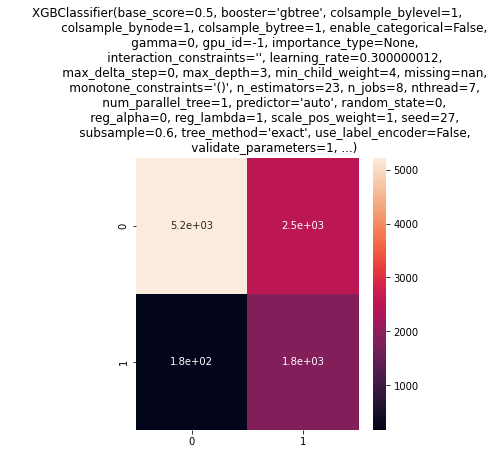

In [ ]:
f1 = result_model(my_xgb, X_test, Y_test)

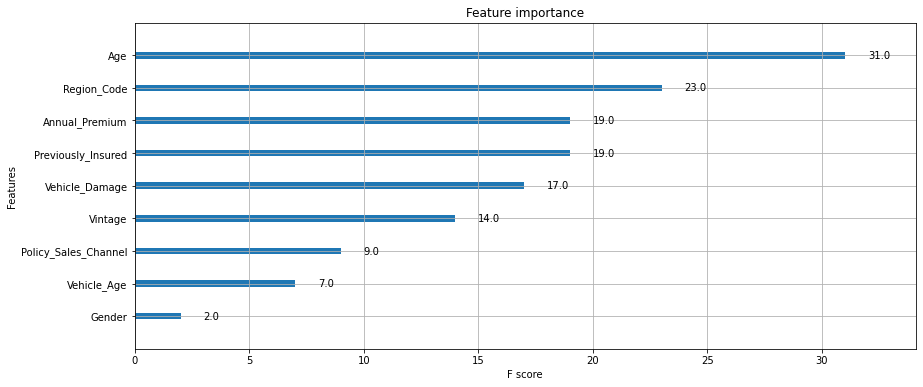

In [18]:
xgb.plot_importance(my_xgb)
plt.show()

## Export des prédictions

Pour le rendu final, nous entrainons la base de données sur toute la bdd train.

**Traitement de la bdd test**

Nous appliquons le même traitement à la bdd test qu'à la bdd train.

In [19]:
test = pd.read_csv("https://www.data.mclavier.com/prj_datascience/brut_test.csv")
test.drop(columns='id', inplace = True)

dict_cat = {'No' : 0, 'Yes' : 1}
test.Vehicle_Damage.replace(dict_cat, inplace = True)

dict_cat = {'Male' : 0, 'Female' : 1}
test.replace(dict_cat, inplace = True)

dict_cat = {152 : 0, 26 : 1, 124 : 2}

def default_dict(x):
    if x in dict_cat:
        return dict_cat[x]
    else:
        return 3

new_damage = test.Policy_Sales_Channel.apply(lambda x : default_dict(x))
test['Policy_Sales_Channel'] = new_damage


dict_age = {'1-2 Year' : 1, '< 1 Year' : 0, '> 2 Years' : 2}
test.replace(dict_age, inplace = True)

X_to_predict = test

In [20]:
X_to_predict.head(3)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,49,1,18,0,1,1,38609,2,180
1,1,26,1,11,1,0,0,18452,0,105
2,1,80,1,28,0,2,1,30245,1,167


Une fois les paramètres sélectionnés, nous ne séparons plus notre base en train/test.

Cependant, nous conservons le *RandomUnderSampler* : 

In [21]:
rus = RandomUnderSampler(sampling_strategy = 0.844)
X_f , Y_f = rus.fit_resample(X ,Y)

Entrainement final :

In [23]:
xgb_final = XGBClassifier(**params_xgb)
xgb_final.fit(X_f, Y_f)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=23, n_jobs=8, nthread=7,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=0.6, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

Nous évaluons les prévisions finale :

In [24]:
Y_predict = xgb_final.predict(X_to_predict)

Puis, nous l'exportons sous le même format que la base de donnée X.

In [25]:
Y_predict = pd.DataFrame(Y_predict)
Y_predict.rename(columns={0:'Response'}, inplace = True)
id_col = pd.read_csv("https://www.data.mclavier.com/prj_datascience/brut_test.csv", usecols=['id']).values
Y_predict['id'] = id_col
Y_predict = Y_predict[['id', 'Response']]

Y_predict.head()

,id,Response
0,1,1
1,2,0
2,3,1
3,4,1
4,5,0


In [32]:
Y_predict.to_csv("groupe_1_predictions.csv", index = False)

Vérification du fichier :

In [34]:
pd.read_csv('https://www.data.mclavier.com/prj_datascience/groupe_1_predictions.csv')

,id,Response
0,1,1
1,2,0
2,3,1
3,4,1
4,5,0
...,...,...
7145,7146,1
7146,7147,0
7147,7148,0
7148,7149,0


## Conclusion

Vous pouvez télécharger le fichier [groupe_1_prediction.csv](https://www.data.mclavier.com/prj_datascience/groupe_1_predictions.csv) pour évaluer le modèle.

<br><br><br><br><br><br><br>